<a href="https://colab.research.google.com/github/nandhukumar86/GL-hackathons-1/blob/main/GL_hackathon_1_Nandha_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Basic Imports

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline


# Load the dataset

In [3]:
fd_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/frequency_domain_features_train.csv')
fd_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/frequency_domain_features_test.csv')
td_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/time_domain_features_train.csv')
td_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/time_domain_features_test.csv')
hr_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/heart_rate_non_linear_features_train.csv')
hr_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/heart_rate_non_linear_features_test.csv')

In [21]:
fd_train.shape, fd_test.shape

((369289, 12), (41033, 12))

In [18]:
fd_train.columns, fd_test.columns

(Index(['uuid', 'VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT',
        'HF_NU', 'TP', 'LF_HF', 'HF_LF'],
       dtype='object'),
 Index(['uuid', 'VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT',
        'HF_NU', 'TP', 'LF_HF', 'HF_LF'],
       dtype='object'))

In [22]:
td_train.shape, td_test.shape

((369289, 20), (41033, 19))

In [19]:
td_train.columns, td_test.columns

(Index(['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
        'pNN25', 'pNN50', 'KURT', 'SKEW', 'MEAN_REL_RR', 'MEDIAN_REL_RR',
        'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR', 'SDRR_RMSSD_REL_RR',
        'KURT_REL_RR', 'SKEW_REL_RR', 'uuid'],
       dtype='object'),
 Index(['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'pNN25',
        'pNN50', 'KURT', 'SKEW', 'MEAN_REL_RR', 'MEDIAN_REL_RR', 'SDRR_REL_RR',
        'RMSSD_REL_RR', 'SDSD_REL_RR', 'SDRR_RMSSD_REL_RR', 'KURT_REL_RR',
        'SKEW_REL_RR', 'uuid'],
       dtype='object'))

HR is the the column to be predicted

In [23]:
hr_train.shape, hr_test.shape

((369289, 7), (41033, 7))

In [20]:
hr_train.columns, hr_test.columns

(Index(['uuid', 'SD1', 'SD2', 'sampen', 'higuci', 'datasetId', 'condition'], dtype='object'),
 Index(['uuid', 'SD1', 'SD2', 'sampen', 'higuci', 'datasetId', 'condition'], dtype='object'))

#Check of distinct uuid

In [29]:
fd_train['uuid'].value_counts().size, td_train['uuid'].value_counts().size, hr_train['uuid'].value_counts().size

(369289, 369289, 369289)

In [32]:
fd_test['uuid'].value_counts().size, td_test['uuid'].value_counts().size, hr_test['uuid'].value_counts().size

(41033, 41033, 41033)

This shows all has unique values

In [30]:
fd_train.head(3)

,uuid,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF
0,89df2855-56eb-4706-a23b-b39363dd605a,2661.894136,72.203287,1009.249419,27.375666,98.485263,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380
1,80c795e4-aa56-4cc0-939c-19634b89cbb2,2314.265450,76.975728,690.113275,22.954139,99.695397,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055
2,c2d5d102-967c-487d-88f2-8b005a449f3e,1373.887112,51.152225,1298.222619,48.335104,98.950472,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607


In [31]:
td_train.head(3)

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,uuid
0,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,-0.856554,0.335218,-0.000203,-0.000179,0.017080,0.007969,0.007969,2.143342,-0.856554,0.335218,89df2855-56eb-4706-a23b-b39363dd605a
1,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,-0.408190,-0.155286,-0.000059,0.000611,0.013978,0.004769,0.004769,2.930855,-0.408190,-0.155286,80c795e4-aa56-4cc0-939c-19634b89cbb2
2,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,0.351789,-0.656813,-0.000011,-0.000263,0.018539,0.008716,0.008716,2.127053,0.351789,-0.656813,c2d5d102-967c-487d-88f2-8b005a449f3e


In [33]:
hr_train.head(3)

,uuid,SD1,SD2,sampen,higuci,datasetId,condition
0,89df2855-56eb-4706-a23b-b39363dd605a,11.001565,199.061782,2.139754,1.163485,2,no stress
1,80c795e4-aa56-4cc0-939c-19634b89cbb2,9.170129,114.634458,2.174499,1.084711,2,interruption
2,c2d5d102-967c-487d-88f2-8b005a449f3e,11.533417,118.939253,2.135350,1.176315,2,interruption


In [65]:
df3 = pd.merge(fd_train, td_train, how='outer', on='uuid')
df_train = pd.merge(df3, hr_train, how='outer', on='uuid')

In [66]:
df_train.shape

(369289, 37)

In [67]:
df2 = pd.merge(fd_test, td_test, how='outer', on='uuid')
df_test = pd.merge(df2, hr_test, how='outer', on='uuid')

In [68]:
df_test.shape

(41033, 36)

In [69]:
df_train.head(3)

,uuid,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,SD1,SD2,sampen,higuci,datasetId,condition
0,89df2855-56eb-4706-a23b-b39363dd605a,2661.894136,72.203287,1009.249419,27.375666,98.485263,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,-0.856554,0.335218,-0.000203,-0.000179,0.017080,0.007969,0.007969,2.143342,-0.856554,0.335218,11.001565,199.061782,2.139754,1.163485,2,no stress
1,80c795e4-aa56-4cc0-939c-19634b89cbb2,2314.265450,76.975728,690.113275,22.954139,99.695397,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,-0.408190,-0.155286,-0.000059,0.000611,0.013978,0.004769,0.004769,2.930855,-0.408190,-0.155286,9.170129,114.634458,2.174499,1.084711,2,interruption
2,c2d5d102-967c-487d-88f2-8b005a449f3e,1373.887112,51.152225,1298.222619,48.335104,98.950472,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,0.351789,-0.656813,-0.000011,-0.000263,0.018539,0.008716,0.008716,2.127053,0.351789,-0.656813,11.533417,118.939253,2.135350,1.176315,2,interruption


In [70]:
df_test.head(3)

,uuid,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,SD1,SD2,sampen,higuci,datasetId,condition
0,62b75db5-bc40-4c8f-9166-daf0efcab4c2,1868.532278,76.511189,570.643114,23.366245,99.478197,2.993254,0.122565,0.521803,2442.168645,190.643094,0.005245,934.665288,939.03173,82.139495,11.801781,11.801772,6.959924,3.933333,0.133333,-0.680262,-0.233075,0.000016,0.000288,0.012933,0.004578,0.004578,2.825038,-0.680262,-0.233075,8.347898,115.862444,2.209659,1.100715,2,time pressure
1,a99549ad-3eb6-4413-bc90-9053e7f7e684,568.742845,26.301350,1553.971621,71.862973,97.509212,39.694850,1.835677,2.490788,2162.409316,39.147940,0.025544,817.062380,816.33879,55.492332,20.558810,20.558768,2.699200,24.600000,0.533333,-0.034454,-0.051689,0.000040,-0.002749,0.025148,0.013921,0.013921,1.806517,-0.034454,-0.051689,14.542096,77.118903,2.186132,1.290615,2,no stress
2,cb573d3a-c767-4556-b32e-ad8c08ded214,2101.871207,75.836461,655.175895,23.639042,97.829386,14.536877,0.524497,2.170614,2771.583978,45.069921,0.022188,876.762022,894.19889,88.690820,13.853737,13.853730,6.401942,7.066667,0.533333,-0.206953,-0.589940,0.000010,-0.000172,0.015533,0.008149,0.008149,1.906180,-0.206953,-0.589940,9.799336,125.044377,2.051571,1.226663,2,no stress


In [71]:
y_train = df_train.pop('HR')

In [72]:
X_train = df_train.copy(deep = True)
X_test = df_test.copy(deep = True)

In [73]:
X_train.shape, X_test.shape

((369289, 36), (41033, 36))

#Checking the distribution of heartrate

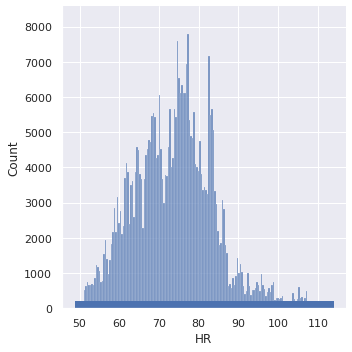

In [74]:
sns.displot(y_train, kde=False, rug=True);

In [75]:
y_train.describe()

count    369289.000000
mean         73.941824
std          10.337453
min          48.737243
25%          66.715776
50%          74.217809
75%          80.334937
max         113.752309
Name: HR, dtype: float64

1. All HR are positive values.
2. Right Sckewed, can bring in log transform to make normalized. Will check that.


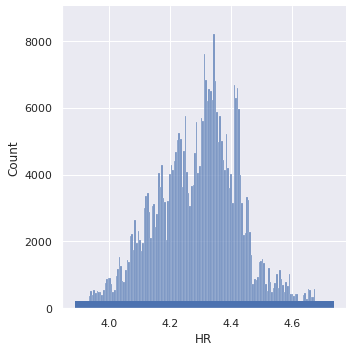

In [76]:
sns.displot(np.log(y_train), kde=False, rug=True);

## Why log?

  y = exp(log(y))

A model will perform better if the data is normally distributed. Since our HR is not normal we will make it normal by log, and say y_norm [check the values]. Train the model with y_norm, predict the y_norm for test data, then during submit take the expo of y_norm to get the yhat.


# Some basic EDA

## Drop datasetId

In [77]:
df_train['datasetId'].value_counts()

2    369289
Name: datasetId, dtype: int64

In [78]:
df_test['datasetId'].value_counts()

2    41033
Name: datasetId, dtype: int64

datasetId contains same values and it doesnot provide any additional information to the model. Hence we will drop the column in both test and train dataset.

In [79]:
df_train.drop(columns= ['datasetId'], inplace=True)
df_test.drop(columns= ['datasetId'], inplace=True)

In [80]:
df_train.condition.value_counts()

no stress        200082
interruption     105150
time pressure     64057
Name: condition, dtype: int64

In [81]:
df_test.condition.value_counts()

no stress        22158
interruption     11782
time pressure     7093
Name: condition, dtype: int64

# Removing high corrleation features

In [82]:
corr_matrix = df_train.corr()            
upper = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
high_correlation_features = [column for column in upper.columns if any(upper[column] > 0.8)]


In [83]:
high_correlation_features

['LF_PCT',
 'HF_PCT',
 'HF_NU',
 'TP',
 'HF_LF',
 'MEDIAN_RR',
 'RMSSD',
 'SDSD',
 'SDRR_RMSSD',
 'pNN25',
 'SDRR_REL_RR',
 'RMSSD_REL_RR',
 'SDSD_REL_RR',
 'KURT_REL_RR',
 'SKEW_REL_RR',
 'SD1',
 'SD2']

In [84]:
df_train.drop(columns= high_correlation_features, inplace=True)
df_test.drop(columns= high_correlation_features, inplace=True)

In [86]:
df_train.drop(columns= ['uuid'], inplace=True)

In [87]:
y_id = df_test.pop('uuid')

In [88]:
df_train.head(5)

,VLF,VLF_PCT,LF,LF_NU,HF,LF_HF,MEAN_RR,SDRR,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_RMSSD_REL_RR,sampen,higuci,condition
0,2661.894136,72.203287,1009.249419,98.485263,15.522603,65.018055,885.157845,140.972741,0.533333,-0.856554,0.335218,-0.000203,-0.000179,2.143342,2.139754,1.163485,no stress
1,2314.265450,76.975728,690.113275,99.695397,2.108525,327.296635,939.425371,81.317742,0.000000,-0.408190,-0.155286,-0.000059,0.000611,2.930855,2.174499,1.084711,interruption
2,1373.887112,51.152225,1298.222619,98.950472,13.769729,94.280910,898.186047,84.497236,0.200000,0.351789,-0.656813,-0.000011,-0.000263,2.127053,2.135350,1.176315,interruption
3,2410.357408,70.180308,1005.981659,98.224706,18.181913,55.328701,881.757865,90.370537,0.133333,-0.504947,-0.386138,0.000112,0.000494,2.050988,2.178341,1.179688,no stress
4,1151.177330,43.918366,1421.782051,96.720007,48.215822,29.487873,809.625331,62.766242,0.200000,-0.548408,-0.154252,-0.000100,-0.002736,1.816544,2.221121,1.249612,no stress


In [89]:
df_test.head(5)

,VLF,VLF_PCT,LF,LF_NU,HF,LF_HF,MEAN_RR,SDRR,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_RMSSD_REL_RR,sampen,higuci,condition
0,1868.532278,76.511189,570.643114,99.478197,2.993254,190.643094,934.665288,82.139495,0.133333,-0.680262,-0.233075,0.000016,0.000288,2.825038,2.209659,1.100715,time pressure
1,568.742845,26.301350,1553.971621,97.509212,39.694850,39.147940,817.062380,55.492332,0.533333,-0.034454,-0.051689,0.000040,-0.002749,1.806517,2.186132,1.290615,no stress
2,2101.871207,75.836461,655.175895,97.829386,14.536877,45.069921,876.762022,88.690820,0.533333,-0.206953,-0.589940,0.000010,-0.000172,1.906180,2.051571,1.226663,no stress
3,5757.544433,90.562305,592.913021,98.817806,7.093235,83.588517,1038.640693,213.725850,1.866667,-0.820407,0.487198,-0.000238,-0.000464,2.225116,2.080910,1.085143,time pressure
4,964.696325,70.256575,374.939530,91.805057,33.468834,11.202647,774.548508,51.577855,0.066667,1.738453,-0.005082,0.000054,-0.000006,1.725606,2.068728,1.252547,interruption


# Heatmap

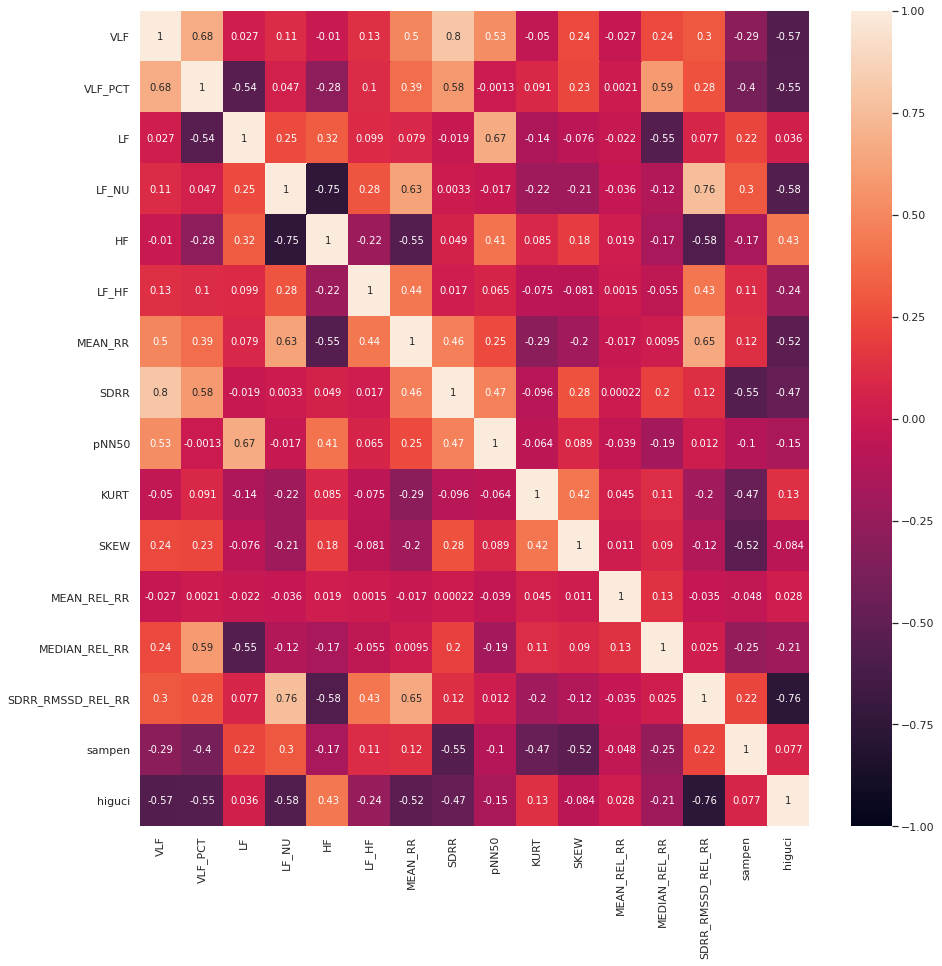

In [91]:
plt.figure(figsize=(15,15))
sns.heatmap(df_train.corr(), annot=True, vmin = -1, vmax = 1);

# Pairplot

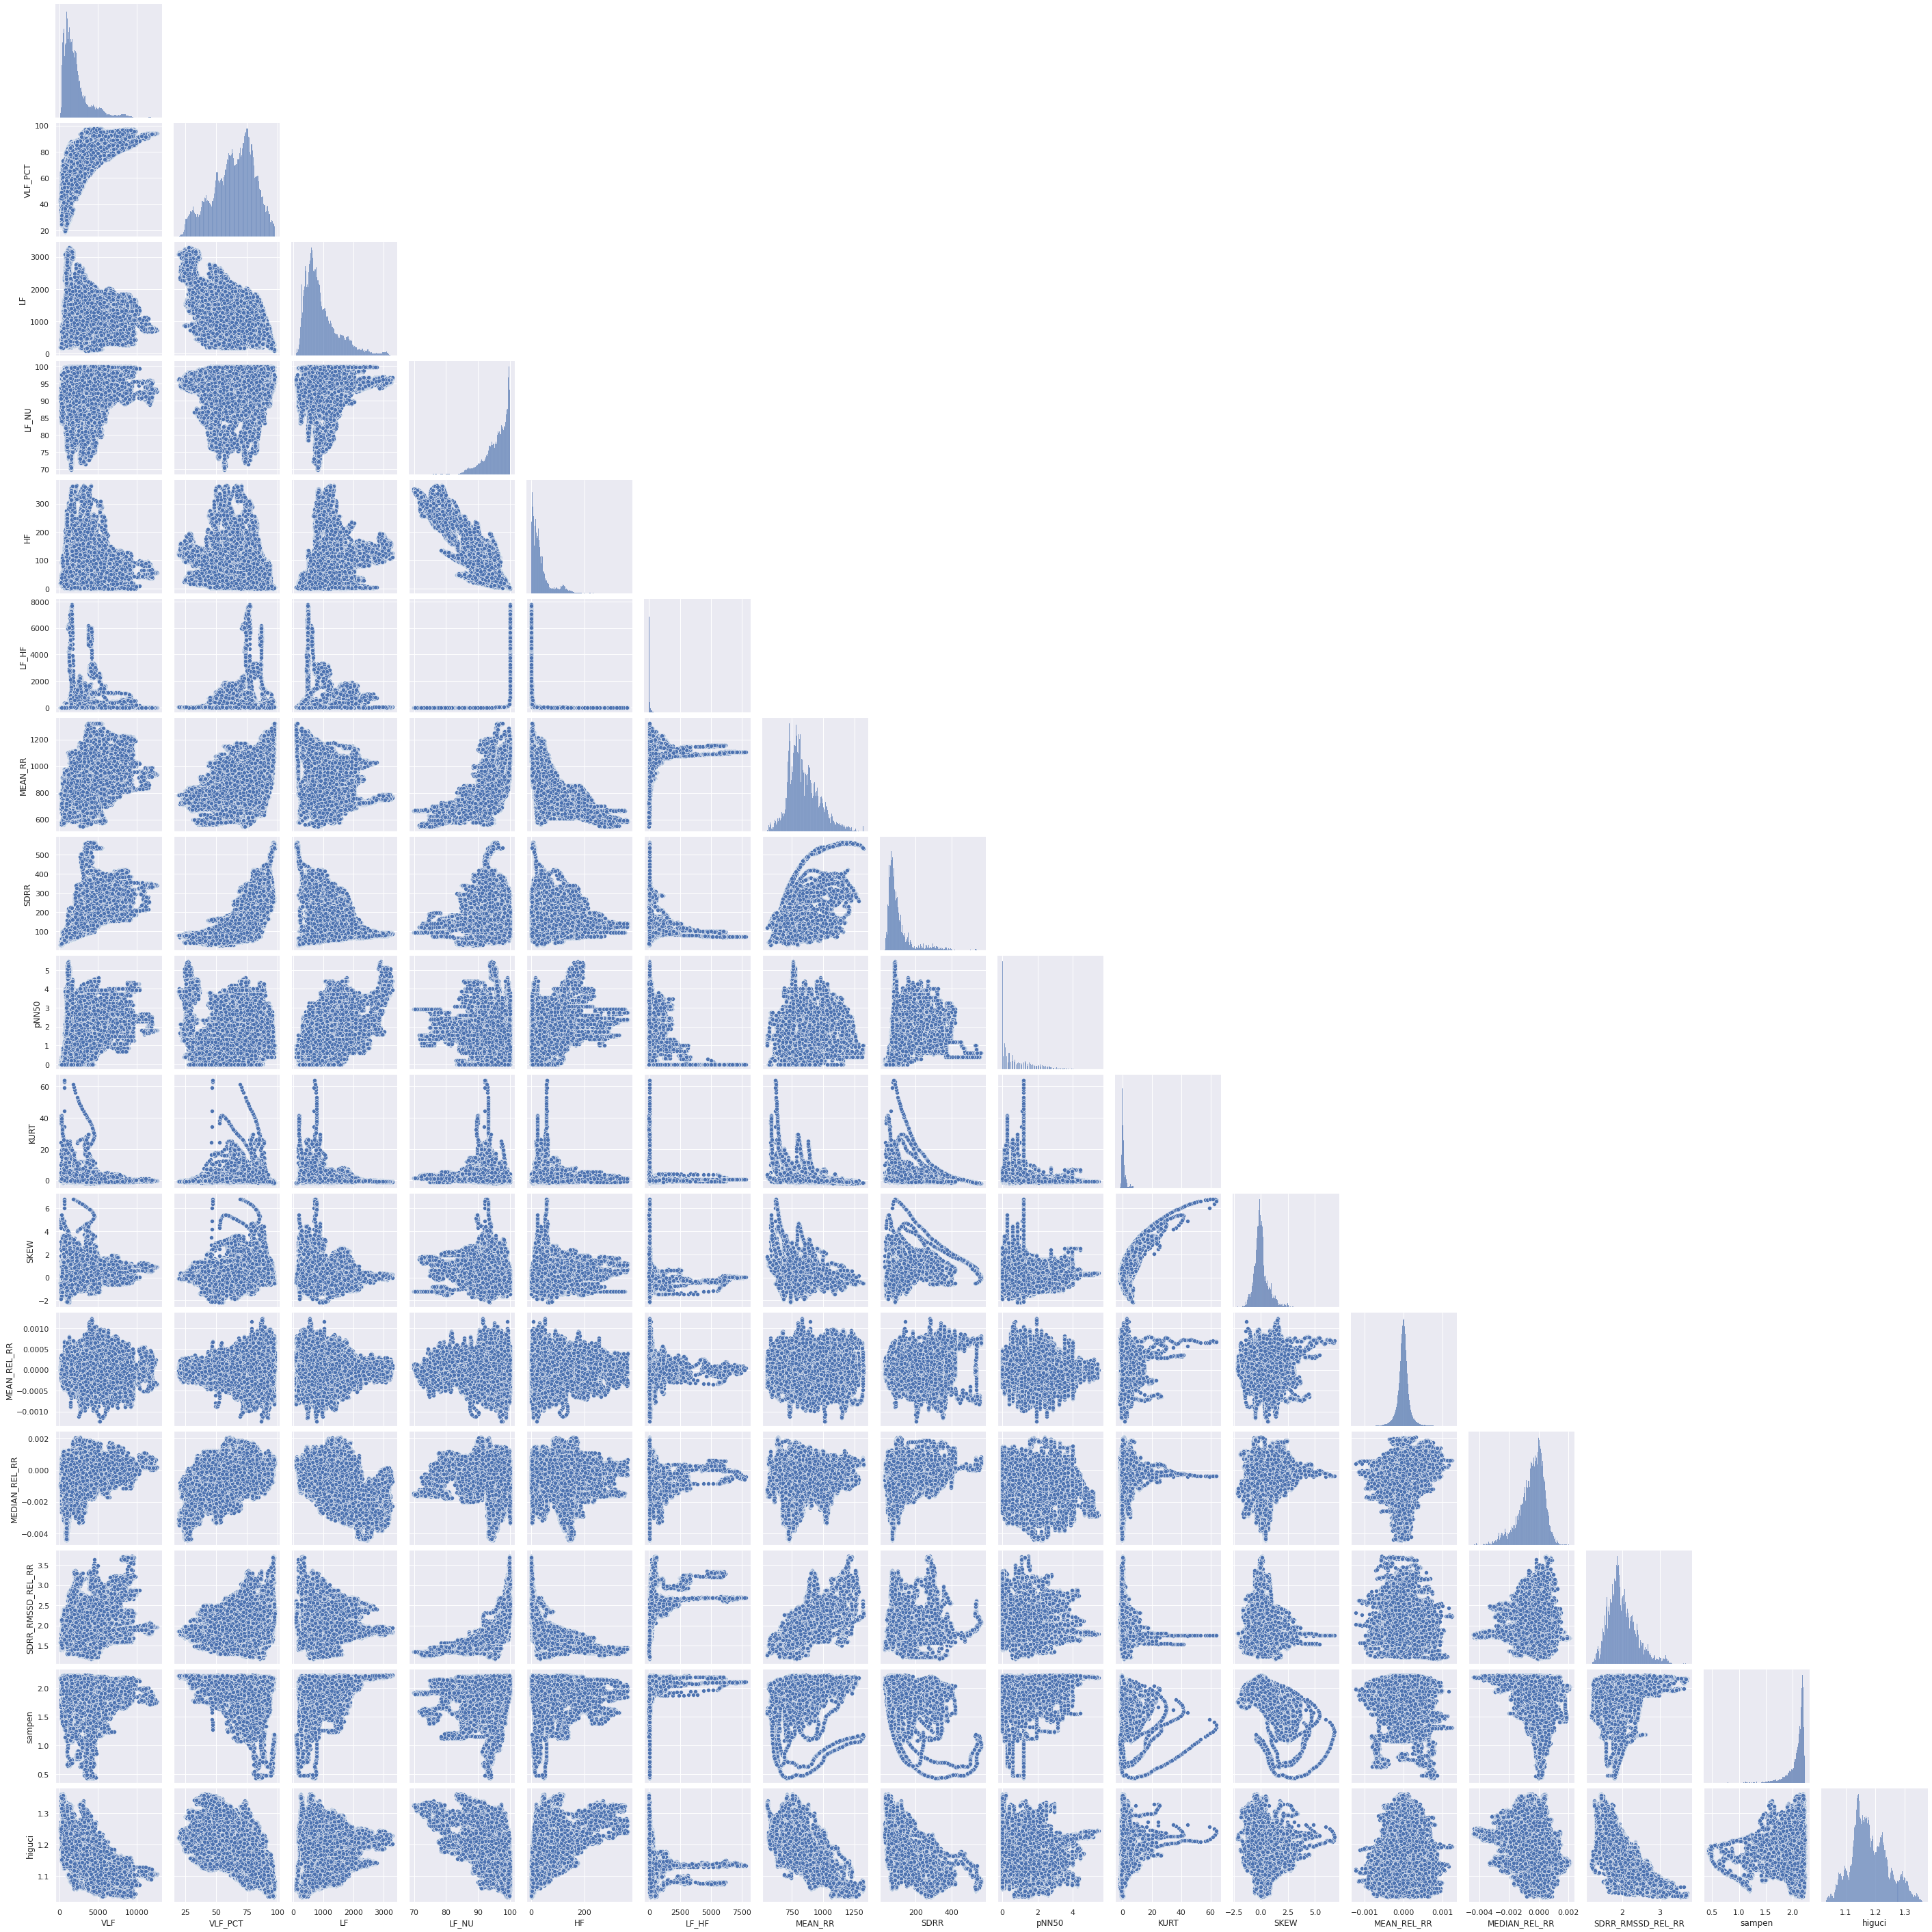

In [92]:
sns.pairplot(df_train, corner=True)